# Build Active Region
Create the synthetic magnetogram, extrapolate the field, trace the loops.

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map
import astropy.units as u
import sunpy.sun.constants as const
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective,HeliographicStonyhurst

import synthesizAR
import synthesizAR.extrapolate

%matplotlib inline

First, make a fake magnetogram with a simple dipolar configuration.

In [11]:
shape = [300, 300] * u.pixel
obs = SkyCoord(lon=0.*u.deg,lat=0.*u.deg,radius=const.au,frame=HeliographicStonyhurst)
blc = SkyCoord(-150 * u.arcsec, -150 * u.arcsec,frame=Helioprojective(observer=obs))
trc = SkyCoord(150 * u.arcsec, 150 * u.arcsec, frame=Helioprojective(observer=obs))
centers = SkyCoord([25, -25,]*u.arcsec,[0, 0,]*u.arcsec,frame=Helioprojective(observer=obs))
sigmas = u.Quantity([[10, 10], [10, 10],],'arcsec')
amplitudes = u.Quantity([1e3, -1e3,], 'Gauss')

In [12]:
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(
    blc,
    trc,
    shape,
    centers,
    sigmas,
    amplitudes,
    observer=obs,
)

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9869-py3.6-linux-x86_64.egg/sunpy/map/mapbase.py:1716: Warning: WCSAxes not being used as the axes object for this plot. Plots may have expected behaviour
  Warning)


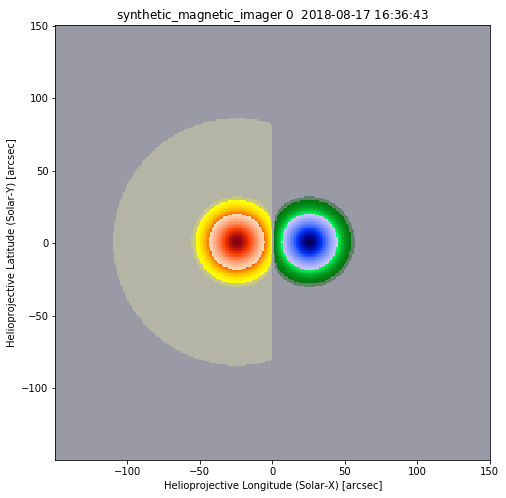

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
magnetogram.plot(axes=ax,cmap='hmimag')

Next, perform a field extrapolation to get $\vec{B}$.

In [14]:
shape_z = 100 * u.pixel
width_z = (magnetogram.scale.axis1 * shape_z).to(u.radian).value * magnetogram.dsun

In [15]:
magnetogram_resample = magnetogram.resample([100,100]*u.pixel)

In [16]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram_resample, width_z, shape_z)

In [17]:
B_field = extrapolator.extrapolate()

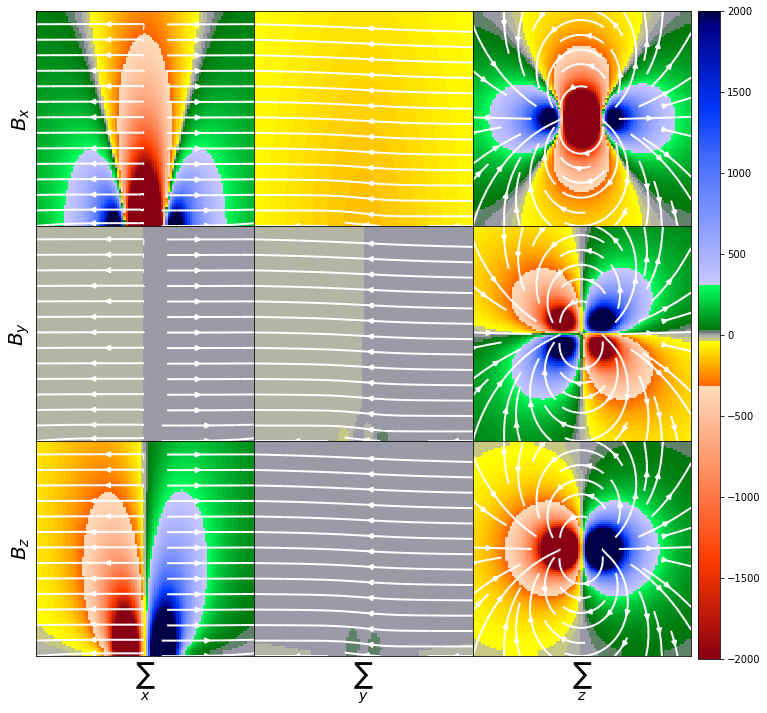

In [18]:
synthesizAR.extrapolate.peek_projections(B_field)

Finally, trace 1000 fieldlines through the extrapolated volume. These will represent our loops.

In [19]:
lines = extrapolator.trace_fieldlines(B_field,1000,loop_length_range=[20,300]*u.Mm,close_threshold=0.05,mask_threshold=0.075,direction=1)

yt : [INFO     ] 2018-08-17 11:48:01,834 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-08-17 11:48:01,835 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-08-17 11:48:01,836 Parameters: domain_left_edge          = [-1.08261934e+10 -1.08261468e+10  0.00000000e+00]
yt : [INFO     ] 2018-08-17 11:48:01,837 Parameters: domain_right_edge         = [1.08333779e+10 1.08333312e+10 7.25270944e+09]
yt : [INFO     ] 2018-08-17 11:48:01,838 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-08-17 11:48:02,896 AMRKDTree rebuilt, Final Volume: 3.402500e+30
Streamlining: 100%|██████████| 1000/1000 [00:04<00:00, 237.72it/s]
yt : [INFO     ] 2018-08-17 11:48:08,920 AMRKDTree rebuilt, Final Volume: 3.402500e+30
Streamlining: 100%|██████████| 432/432 [00:02<00:00, 188.16it/s]
yt : [INFO     ] 2018-08-17 11:48:12,429 AMRKDTree rebuilt, Final Volume: 3.402500e+30
Streamlining: 100%|██████████| 169/169 [00:00<00:00, 208.89it/s]
yt : [INFO     ] 2

FloatProgress(value=0.0)

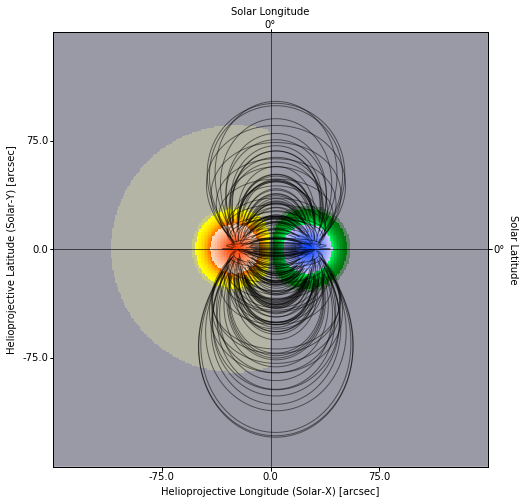

In [20]:
synthesizAR.extrapolate.peek_fieldlines(magnetogram,[l[0] for l in lines])

In [21]:
ar = synthesizAR.Field(magnetogram_resample,lines)

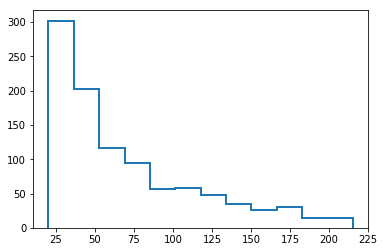

In [23]:
plt.hist([l.full_length.to(u.Mm).value for l in ar.loops],histtype='step',lw=2,bins='scott');

In [24]:
ar.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/simple_dipole/base_field')